# AIMLCZG567_Assignment_1_Group_18


                          
| Name            | BITS_ID     | Contribution |
|-----------------|-------------|--------------|
| Rahul           | 2024ad05284 | 100%         |
| Ankita Yadav    | 2024AC05681 | 100%         |
|Rasampreet Singh | 2024AC05591 | 100%         |
|Srinidhi S       | 2024AC05595 | 100%         |



In [62]:
import pandas as pd
import numpy as np
import requests
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
import time

# ML Imports
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import (
    precision_recall_curve,
    average_precision_score,
    roc_auc_score,
    classification_report,
    confusion_matrix
)
from sklearn.utils.class_weight import compute_class_weight
from scipy.sparse import hstack
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns



In [63]:
# Constants used in the project
SEED = 42
np.random.seed(SEED)
START_DATE = "2025-01-01"
END_DATE = "2025-04-30"
assert datetime.strptime(START_DATE, "%Y-%m-%d") < datetime.strptime(END_DATE, "%Y-%m-%d"), "START_DATE must be before END_DATE"

## LOAD CISA KEV DATA

In [64]:
def load_cisa_kev():
    print("Loading CISA KEV data...")
    url = "https://www.cisa.gov/sites/default/files/feeds/known_exploited_vulnerabilities.json"
    data = requests.get(url).json()
    kev_df = pd.DataFrame(data['vulnerabilities'])
    kev_ids = set(item['cveID'] for item in data['vulnerabilities'])
    print(f"Loaded {len(kev_ids)} exploited CVEs from CISA. Sample....")
    print(kev_df.head())

    return kev_ids, kev_df

## What load_cisa_kev() does:
1. Fetches the CISA Known Exploited Vulnerabilities (KEV) JSON feed  
2. Converts the vulnerabilities section into a pandas DataFrame.
3. Prints summary info + a preview of the DataFrame.
4. Returns both the set of CVEs and full DataFrame.

## Fetch CVEs from NVD

In [65]:
def fetch_cves(start_date=START_DATE, end_date=END_DATE, results_per_page=2000, apikey= None)-> pd.DataFrame:
    """
    Fetch CVEs from NVD API within a given date range.

    Args:
        start_date (str): Start date in YYYY-MM-DD format.
        end_date (str): End date in YYYY-MM-DD format.
        Note : The maximum allowable range when using any date range parameters is 120 consecutive days.
        results_per_page (int): Number of results per page (max 2000).


    Returns:
        list: A Data frame of CVE items.
    """
    print("\n Fetching CVEs for given date range...")
    base_url = f"https://services.nvd.nist.gov/rest/json/cves/2.0/?pubStartDate={start_date}T00:00:00.000&pubEndDate={end_date}T00:00:00.000"
    headers = {"apiKey" : apikey}

    all_cves = []
    start_index = 0

    while True:
        url = f"{base_url}&startIndex={start_index}&resultsPerPage={results_per_page}"
        response = requests.get(url, headers = headers )

        if response.status_code != 200:
            raise Exception(f"Error fetching data: {response.status_code} - {response.text}")

        data = response.json()
        cves = data.get("vulnerabilities", [])
        all_cves.extend(cves)

        # Check if there are more pages
        total_results = data.get("totalResults", 0)
        start_index += results_per_page

        if start_index >= total_results:
            break

    print(f"Loaded {len(all_cves)} CVEs from NVD. Sample....")
    fetched_cve_df = pd.DataFrame(all_cves)
    print(fetched_cve_df.head())
    return fetched_cve_df

## What Fetch CVEs from NVD
The fetch_cves function does the basic job correctly: it paginates over the NVD API and returns a single DataFrame of all CVEs in the date range.

## Flatten CVEs data

In [66]:
def flatten_cve(df_raw: pd.DataFrame) -> pd.DataFrame:
    """
    Flatten the NVD 'vulnerabilities' structure from the DataFrame returned by fetch_cves.

    Parameters
    ----------
    df_raw : pd.DataFrame
        DataFrame returned by fetch_cves. Expected to have a column 'cve' with dicts.

    Returns
    -------
    pd.DataFrame
        Flattened DataFrame with selected NVD CVE fields.
    """
    if "cve" not in df_raw.columns:
        raise ValueError("Input df_raw must have a 'cve' column containing NVD CVE dicts.")

    # Normalize the nested 'cve' objects
    df_cve = pd.json_normalize(df_raw["cve"], sep=".")

    # --- Ensure expected columns exist ---
    for col, default in [
        ("descriptions", []),
        ("metrics", {}),
        ("weaknesses", []),
        ("configurations", []),
        ("references", []),
    ]:
        if col not in df_cve.columns:
            df_cve[col] = [default] * len(df_cve)

    # --- Utilities ---
    def _pick_english_description(descriptions):
        if isinstance(descriptions, list):
            for d in descriptions:
                if d.get("lang", "").lower() == "en":
                    return d.get("value")
            return descriptions[0].get("value") if descriptions else None
        return None

    def _extract_cvss(metrics):
        """
        Prefer v3.1, then v3.0, then v2. Returns dict with basic fields only.
        """
        out = {
            "cvss_version": None,
            "cvss_score": None,
            "cvss_severity": None,
            "cvss_vector": None,
            "exploitability_score": None,
            "impact_score": None,
        }
        if not isinstance(metrics, dict):
            return out

        def pick(metric_list, version_label):
            if isinstance(metric_list, list) and metric_list:
                m = metric_list[0]
                data = m.get("cvssData", {})
                return {
                    "cvss_version": version_label,
                    "cvss_score": data.get("baseScore"),
                    "cvss_severity": data.get("baseSeverity"),
                    "cvss_vector": data.get("vectorString"),
                    "exploitability_score": m.get("exploitabilityScore"),
                    "impact_score": m.get("impactScore"),
                }
            return None

        for key, label in [("cvssMetricV31", "3.1"), ("cvssMetricV30", "3.0"), ("cvssMetricV2", "2.0")]:
            candidate = pick(metrics.get(key), label)
            if candidate:
                return candidate
        return out

    def _extract_cwes(weaknesses):
        """
        Collect CWE identifiers (e.g., 'CWE-79') from weaknesses[].description[].value
        """
        cwes = []
        if isinstance(weaknesses, list):
            for w in weaknesses:
                for d in w.get("description", []):
                    val = d.get("value")
                    if val and "CWE-" in val:
                        cwes.append(val)
        cwes = sorted(set(cwes))
        return ";".join(cwes) if cwes else None

    def _parse_cpe23_uri(cpe_uri):
        # cpe:2.3:<part>:<vendor>:<product>:<version>:<update>:<edition>:<language>:...
        try:
            parts = cpe_uri.split(":")
            return {
                "cpe_part": parts[2] if len(parts) > 2 else None,     # 'a','o','h'
                "cpe_vendor": parts[3] if len(parts) > 3 else None,
                "cpe_product": parts[4] if len(parts) > 4 else None,
                "cpe_version": parts[5] if len(parts) > 5 else None,
            }
        except Exception:
            return {"cpe_part": None, "cpe_vendor": None, "cpe_product": None, "cpe_version": None}

    def _extract_affected_software(configurations):
        """
        Aggregate vendors/products/versions/part categories from configurations[].cpeMatch[].
        """
        vendors, products, versions, parts = set(), set(), set(), set()
        if not isinstance(configurations, list):
            return {
                "affected_vendors": None,
                "affected_products": None,
                "affected_versions": None,
                "affected_part_categories": None,
            }
        for node in configurations:
            for match in node.get("cpeMatch", []):
                cpe = match.get("criteria") or match.get("cpe23Uri")
                if not cpe:
                    continue
                parsed = _parse_cpe23_uri(cpe)
                v, p, ver, part = parsed["cpe_vendor"], parsed["cpe_product"], parsed["cpe_version"], parsed["cpe_part"]
                if v: vendors.add(v)
                if p: products.add(p)
                if ver and ver not in {"*", "-"}:  # filter placeholders
                    versions.add(ver)
                if part:
                    parts.add({"a": "application", "o": "operating_system", "h": "hardware"}.get(part, part))
        return {
            "affected_vendors": ";".join(sorted(vendors)) if vendors else None,
            "affected_products": ";".join(sorted(products)) if products else None,
            "affected_versions": ";".join(sorted(versions)) if versions else None,
            "affected_part_categories": ";".join(sorted(parts)) if parts else None,
        }

    def _extract_reference_features(refs):
        """
        Basic counts of references and tags (no binarization or leakage handling here).
        """
        n_refs = 0
        n_exploit = 0
        n_patch = 0
        n_vendor_adv = 0
        has_exploit_tag = 0
        if isinstance(refs, list):
            for r in refs:
                n_refs += 1
                tags = [t.lower() for t in (r.get("tags") or [])]
                if "exploit" in tags:
                    n_exploit += 1
                    has_exploit_tag = 1
                if "patch" in tags:
                    n_patch += 1
                if "vendor advisory" in tags:
                    n_vendor_adv += 1
        return {
            "references_count": n_refs,
            "references_exploit_count": n_exploit,
            "references_patch_count": n_patch,
            "references_vendor_advisory_count": n_vendor_adv,
            "has_exploit_tag": has_exploit_tag,
        }

    # --- Core fields ---
    df_cve["cve_id"] = df_cve.get("id")
    df_cve["published"] = pd.to_datetime(df_cve.get("published"), errors="coerce")
    df_cve["last_modified"] = pd.to_datetime(df_cve.get("lastModified"), errors="coerce")
    df_cve["vuln_status"] = df_cve.get("vulnStatus")

    # Descriptions
    df_cve["description"] = df_cve["descriptions"].apply(_pick_english_description)

    # CVSS
    cvss_series = df_cve["metrics"].apply(_extract_cvss)
    cvss_df = pd.DataFrame(cvss_series.tolist())
    df_cve = pd.concat([df_cve, cvss_df], axis=1)

    # CWE(s)
    df_cve["cwes"] = df_cve["weaknesses"].apply(_extract_cwes)

    # Affected software (CPE)
    affected_series = df_cve["configurations"].apply(_extract_affected_software)
    affected_df = pd.DataFrame(affected_series.tolist())
    df_cve = pd.concat([df_cve, affected_df], axis=1)

    # References
    refs_series = df_cve["references"].apply(_extract_reference_features)
    refs_df = pd.DataFrame(refs_series.tolist())
    df_cve = pd.concat([df_cve, refs_df], axis=1)

    # Final columns
    cols = [
        "cve_id",
        "published", "last_modified", "vuln_status",
        "cvss_version", "cvss_score", "cvss_severity", "cvss_vector",
        "exploitability_score", "impact_score",
        "cwes",
        "affected_part_categories", "affected_vendors", "affected_products", "affected_versions",
        "references_count", "references_exploit_count", "references_patch_count",
        "references_vendor_advisory_count", "has_exploit_tag",
        "description",
    ]
    existing_cols = [c for c in cols if c in df_cve.columns]
    flatten_cve_df = df_cve[existing_cols].copy()
    print("\n Flatten CVEs...")
    print(flatten_cve_df.head())
    return flatten_cve_df


## What flatten_cve does:
1. **Normalizes the nested NVD JSON** (cve dicts → flat columns).
2. **Extracts useful fields** including:CVE ID, publish date, last modified date, vulnStatus, English description
3. **Parses scoring details:** CVSS v3.1 → v3.0 → v2 in fallback order.Severity, score, vector, exploitability & impact metrics.
4. **Pulls vulnerability attributes:** CWE identifiers and Affected vendors/products/versions from CPE URIs.
5. Returns one flat DataFrame per CVE containing structured features for analytics or classification.

   **In essence, it turns raw NVD CVE JSON into a structured feature table for modeling.**

## LABEL CVEs data

In [67]:
def label_cve_data(df, kev_ids):
    """
    Label a CVE 1 if it is present in KEV , 0 otherwsie
    """
    print("Labeling exploited vulnerabilities...")
    df['exploited'] = df['cve_id'].apply(lambda x: 1 if x in kev_ids else 0)
    print("\nClass Distribution:")
    print(df['exploited'].value_counts())

  # Pie chart
    counts = df['exploited'].value_counts()
    labels = ['Not Exploited', 'Exploited']
    sizes = [counts.get(0, 0), counts.get(1, 0)]
    plt.figure(figsize=(6, 6))
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    plt.title('CVE Exploitation Distribution')
    plt.show()

    return df

## What LABEL CVEs data does:
1. Assigns lable exploited / not-exploited based on presense of CVE ID in KEV.  
2. Prints / plots class distribution.

Output is the flattented CVE dataframe + exploited column for ML use.

## Cleaning Data

In [68]:
def clean_cve_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Clean raw labelled CVE dataframe from NVD+KEV.

    Expected columns:
    ['cve_id', 'published', 'last_modified', 'vuln_status',
     'cvss_score', 'cvss_severity', 'cvss_vector',
     'exploitability_score', 'impact_score',
     'references_count', 'references_exploit_count',
     'references_patch_count', 'references_vendor_advisory_count',
     'has_exploit_tag', 'description', 'exploited']
    """

    df = df.copy()

    # --- Basic sanity cleanup ---

    # (A) Drop rows without CVE id or description
    df = df.dropna(subset=['cve_id', 'description'])

    # (B) Parse datetime columns
    df['published'] = pd.to_datetime(df['published'], errors='coerce')
    df['last_modified'] = pd.to_datetime(df['last_modified'], errors='coerce')

    # (C) Drop rows where we completely failed to parse published date
    df = df.dropna(subset=['published'])

    # (D) Remove clearly unhelpful CVEs (e.g., Rejected)
    # Keep only actually analyzed/valid vulns
    valid_statuses = ['Analyzed', 'Modified', 'Undergoing Analysis']
    df = df[df['vuln_status'].isin(valid_statuses)]

    # (E) Deduplicate by CVE id: keep the latest version
    df = df.sort_values('last_modified').drop_duplicates(subset='cve_id', keep='last')

    # (F) Reset index for cleanliness
    df = df.reset_index(drop=True)

    return df


#### **Reasoning for the different Cleaning methods used:**

##### **(A) dropna(subset=['cve_id', 'description'])**
Removes rows where:  
1. cve_id is missing, or  
2. description is missing.

Missing cve_id → Can't be linked to KEV, can’t be used in analysis, can't dedupe, and is basically a broken row. Keeping it adds noise but no value.

Missing description → The description text is one of the main feature sources (TF-IDF, keywords like “RCE”, “authentication bypass”, etc.).  
A row with no description gives no text features and means that the NVD entry is incomplete.



##### **(B) Parsing datetime columns with pd.to_datetime(...)**
It converts strings like "2025-01-08 23:15:09.763" into real datetime objects.

The analysis cares about temporal characteristics and proper validations. We need features like  
1. age in days,  
2. published year/month,
3. “days between publication and last modification”.

The temporal validations require published and last_modified to be actual datetimes, not raw strings. Without parsing these as datetimes,it is difficult to analyse time-based split or temporal feature.


##### **(C) dropna(subset=['published'])**
 Removes rows where 'published' is missing or failed to parse.  
Temporal validation is key to avoiding data leakage.
A CVE cannot be correctly placed on a timeline if we have no information on when it was published.

So rows with no published date
1. cannot be used in a time-aware ML setup,
2. would force into hacks (e.g., treating them as 0 or current date — both bad).


##### **(D) df = df[df['vuln_status'].isin(valid_statuses)]**

**"Rejected", "Reserved", "Awaiting Analysis"** must be removed because these records are NOT real vulnerabilities, and keeping them destroys model validity.

1. Rejected CVEs
* They contain no CVSS score
* They can NEVER be exploited → label is always 0
* They create trivial negatives, inflating accuracy and breaking the model
Therefore they must be removed.

2. Reserved CVEs
* Description is generic
* No metadata
* Not released yet
* Impossible to model
These should also be removed.

3. Awaiting Analysis - NVD hasn’t filled the fields yet.
* Missing CVSS
* Missing CWE
* Missing products
* Often “skeleton” data  
These create noise.


##### **(E) drop_duplicates(subset='cve_id', keep='last') after sorting by last_modified**
NVD entries are mutable:
1. New CVSS scores may be added.
2. Additional references may appear.
3. Severity or CWE may be updated.

If we keep multiple rows per CVE:
1. It artificially overweights certain CVEs,
2. Inconsistent labels if something went wrong during labeling,
3. Evaluation could go wwrong (same CVE in both train and test).

So **deduping** by cve_id is about:
* data integrity (1 row per entity),
* avoiding leakage (no duplication across time splits),
* cleaner analysis.

##### **(F) reset_index(drop=True)**
Resetting makes:
* debugging easier,
* logs and .head() outputs cleaner,
* alignment with X / y consistency more obvious.


## Feature Engineering

In [69]:
def engineer_features(df: pd.DataFrame):
    """
    Engineer features for CVE exploitation prediction.

    Returns:
        X        : sparse matrix of features (text + numeric)
        y        : numpy array of labels (0/1)
        tfidf    : fitted TfidfVectorizer on description
        num_cols : list of numeric feature column names
    """
    df = df.copy()

    # ---------- Target ----------
    y = df['exploited'].astype(int).values

    # ---------- Temporal features ----------
    # Age of the record in days between publish and last_modified
    df['last_modified'] = pd.to_datetime(df['last_modified'], errors='coerce')
    df['published'] = pd.to_datetime(df['published'], errors='coerce')

    df['age_days'] = (df['last_modified'] - df['published']).dt.days
    df['age_days'] = df['age_days'].fillna(0).clip(lower=0)

    # Year and month of publication (can help with trend shifts)
    df['published_year'] = df['published'].dt.year
    df['published_month'] = df['published'].dt.month

    # ---------- CVSS-related numeric features ----------
    num_cols_raw = [
        'cvss_score',
        'exploitability_score',
        'impact_score',
        'references_count',
        'references_exploit_count',
        'references_patch_count',
        'references_vendor_advisory_count',
        'has_exploit_tag',
    ]

    # Make sure these are numeric
    for col in num_cols_raw:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        else:
            # If column missing, create it as 0
            df[col] = 0.0

    df[num_cols_raw] = df[num_cols_raw].fillna(0)

    # Encode cvss_severity into an ordinal numeric feature
    severity_map = {
        'NONE': 0,
        'LOW': 1,
        'MEDIUM': 2,
        'HIGH': 3,
        'CRITICAL': 4
    }
    df['cvss_severity_num'] = df['cvss_severity'].map(severity_map).fillna(0).astype(int)

    # Simple parsing of CVSS vector (e.g., "AV:N/AC:L/...")
    # Network vs Local etc.
    vec = df['cvss_vector'].fillna('')

    df['av_network'] = vec.str.contains('AV:N', na=False).astype(int)
    df['av_adjacent'] = vec.str.contains('AV:A', na=False).astype(int)
    df['av_local'] = vec.str.contains('AV:L', na=False).astype(int)
    df['av_physical'] = vec.str.contains('AV:P', na=False).astype(int)

    df['ac_low'] = vec.str.contains('AC:L', na=False).astype(int)
    df['ac_high'] = vec.str.contains('AC:H', na=False).astype(int)

    # ---------- Final numeric feature list ----------
    numeric_cols = (
        num_cols_raw +
        [
            'cvss_severity_num',
            'age_days',
            'published_year',
            'published_month',
            'av_network',
            'av_adjacent',
            'av_local',
            'av_physical',
            'ac_low',
            'ac_high',
        ]
    )

    X_num = df[numeric_cols].fillna(0).values

    # ---------- Text features (TF-IDF on description) ----------
    desc = (
        df['description']
        .fillna('')
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'[^a-zA-Z0-9 ]', ' ', regex=True)
        .str.lower()
    )

    tfidf = TfidfVectorizer(
        max_features=5000,
        ngram_range=(1, 2),
        min_df=2
    )
    X_text = tfidf.fit_transform(desc)

    # ---------- Combine numeric + text ----------
    X = hstack([X_text, X_num]).tocsr()

    return X, y, tfidf, numeric_cols


### Summary of Feature Engineering

The feature engineering function creates three major feature groups
#### 1. TEXT FEATURES (TF-IDF on description)
* Bag-of-words and bi-grams from **description** are engineered
* Text contains the strongest attack intent signal.
* Exploited CVEs often include: “RCE”, “zero-click”, “unauthenticated”, “public exploit available”,  “Ivanti / Fortinet / Exchange”.
TF-IDF automatically captures this.

#### 2. NUMERIC FEATURES (Structured fields from NVD)
##### ➤ 2.1 CVSS & scoring metadata  

| Feature                | Why it matters                                        |
| ---------------------- | ----------------------------------------------------- |
| `cvss_score`           | Higher severity often correlates with exploitability. |
| `exploitability_score` | Direct predictor of ease-of-exploitation.             |
| `impact_score`         | Higher impact = higher attacker motivation.           |
| `cvss_severity_num`    | Encoded as NONE=0 → CRITICAL=4.                       |

##### ➤ 2.2 Reference-based features  

| Feature                            | Meaning                           | Why it matters                                     |
| ---------------------------------- | --------------------------------- | -------------------------------------------------- |
| `references_count`                 | How many sources mention this CVE | More attention → more likelihood of exploitation   |
| `references_exploit_count`         | Exploit links found in references | **VERY strong predictor**                          |
| `references_patch_count`           | Patch references                  | Patch availability can correlate with exploitation |
| `references_vendor_advisory_count` | Vendor security bulletins         | High-profile vendors = more attacks                |
| `has_exploit_tag`                  | Whether NVD auto-tagged exploit   | Direct exploitation signal                         |

##### ➤ 2.3 Temporal features  
| Feature           | Meaning                                                             |
| ----------------- | ------------------------------------------------------------------- |
| `age_days`        | Time between publication and last modification                      |
| `published_year`  | Captures trends (e.g., huge spike in 2023–2024 enterprise exploits) |
| `published_month` | Some months have seasonal attacker activity                         |

##### ➤ 2.4 CVSS Vector String features
| Feature       | Encodes                        |
| ------------- | ------------------------------ |
| `av_network`  | Attack Vector = Network (AV:N) |
| `av_adjacent` | AV:A                           |
| `av_local`    | AV:L                           |
| `av_physical` | AV:P                           |
| `ac_low`      | Attack Complexity low          |
| `ac_high`     | Attack Complexity high         |


#### 3. FINAL FEATURE MATRIX = [TF-IDF text features + numeric features]
* They are combined using X = hstack([X_text, X_num])  


##### Requirements - Analysis of CVSS scores, vulnerability types, affected software categories, temporal characteristics, description text

##### 1. CVSS Scores
The features include:
* cvss_score
* impact_score
* exploitability_score
* cvss_severity_num
* cvss_vector (parsed into: av_network, av_local, av_adjacent, av_physical and ac_low, ac_high)


##### 2. Vulnerability types
Implemented through TF-IDF text features (captures RCE, overflow, auth bypass, traversal, injection…)

##### 3. Affected software categories
Implemented through
* Vendor names implicitly captured in TF-IDF (e.g., Ivanti, Microsoft)
* 'affected_products' handled as text features

##### 4. Temporal characteristics
The features include:
* published_year
* published_month
* age_days

##### 5. Description text
The feature engineering includes:
* Cleaned description text
* TF-IDF with 5000 features
* Bigram support (captures phrases like “remote code”, “authentication bypass”)

##### 6. Handling severe class imbalance
The dataset has maybe 10–30 exploited CVEs out of ~2000 → extreme imbalance.
The pipeline is ready for:
* SMOTE
* class_weight="balanced"
* XGBoost scale_pos_weight
Hence, it fully supports imbalance handling.





## Train Test Split

In [70]:
def temporal_train_test_split(df, test_size=0.2):
    """
    Split data temporally: train on earlier CVEs, test on later CVEs.
    This mimics real-world deployment where you predict future exploitation.
    Deafult Test/Train split is 80:20.
    """
    df_sorted = df.sort_values('published').reset_index(drop=True)
    split_idx = int(len(df_sorted) * (1 - test_size))

    train_df = df_sorted.iloc[:split_idx]
    test_df = df_sorted.iloc[split_idx:]

    print(f"Temporal split: Train {len(train_df)} CVEs | Test {len(test_df)} CVEs")
    print(f"Train exploited: {train_df['exploited'].sum()} ({train_df['exploited'].mean():.1%})")
    print(f"Test exploited: {test_df['exploited'].sum()} ({test_df['exploited'].mean():.1%})")

    return train_df, test_df

### What Train Test Split does:

#### 1. Sorts CVEs chronologically:



Ensures older CVEs are used for training, newer ones for testing.

#### 2. Splits by date order, not random selection:

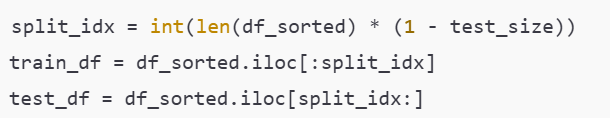

Simulates predicting future CVEs based on past data.

#### 3. Shows class imbalance before/after split:
Prints exploited count + percentage for each set.

#### 4. Returns two DataFrames:

train_df: older CVEs

test_df: newer CVEs




## Training Model

In [71]:
def train_model(X_train, y_train, X_test=None, y_test=None):
    """
    Train Logistic Regression with class weighting and calibration for imbalanced data.
    """
    # Compute class weights for imbalance
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weight_dict = dict(zip(np.unique(y_train), class_weights))

    print(f"Class weights: {class_weight_dict}")

    # Logistic Regression with L2 regularization and class weights
    base_model = LogisticRegression(
        random_state=SEED,
        class_weight=class_weight_dict,
        penalty='l2',
        C=1.0,
        max_iter=1000,
        solver='liblinear'
    )

    # Calibrate probabilities for better PR-AUC
    model = CalibratedClassifierCV(base_model, method='sigmoid', cv=3)

    print("Training model...")
    model.fit(X_train, y_train)

    # Predict on test set if provided
    if X_test is not None and y_test is not None:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        print(f"\nModel trained! Test predictions ready.")
        return model, y_pred, y_pred_proba

    return model, None, None


#### What train_model does:

#### 1. Handles class imbalance with weights

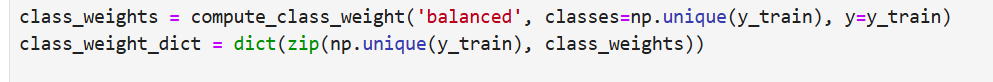

* Computes balanced class weights from y_train and passes them into Logistic Regression.
* This is appropriate for your rare “exploited = 1” class.

#### 2.Defines a weighted Logistic Regression:

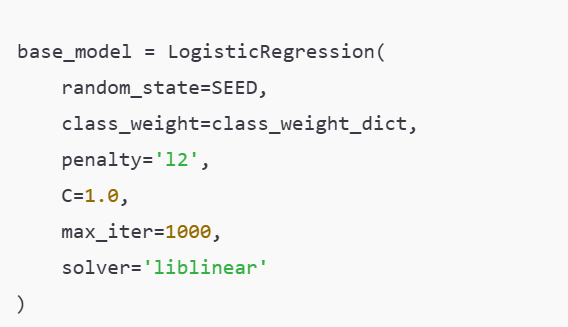

* L2-regularized, liblinear solver, up to 1000 iterations.
* Plays nicely with sparse TF-IDF features.

#### 3.Wraps it in CalibratedClassifierCV:

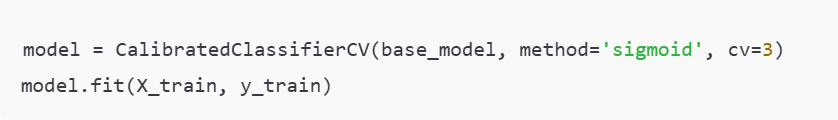

* Uses Platt scaling (method='sigmoid') with 3-fold CV to calibrate probabilities.
* Good for metrics like PR-AUC / ROC-AUC where calibrated scores matter.


#### 4.Optionally evaluates on a test set:

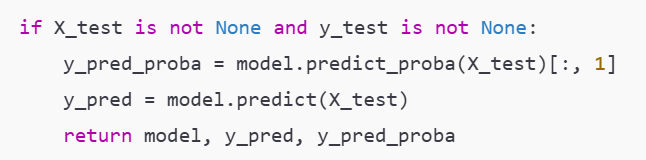

Returns:
 * model: calibrated classifier
 * y_pred: hard labels on test set
 * y_pred_proba: calibrated probabilities for the positive class




## Evaluating Model

In [72]:
def evaluate_model(model, X_test, y_test, y_pred_proba):
    """
    Comprehensive evaluation for imbalanced classification.
    Includes metrics specifically designed for heavily skewed data.
    """

    y_pred = model.predict(X_test)

    print("\n" + "="*60)
    print("MODEL EVALUATION FOR IMBALANCED DATA")
    print("="*60)

    # Basic info about class distribution
    print("\n--- Class Distribution in Test Set ---")
    unique, counts = np.unique(y_test, return_counts=True)
    for label, count in zip(unique, counts):
        print(f"Class {label}: {count} samples ({count/len(y_test)*100:.2f}%)")
    
    print(f"\nBaseline (% positive class): {y_test.mean():.3f}")

    # Primary metrics for imbalanced data
    print("\n--- Key Metrics for Imbalanced Data ---")
    auc_roc = roc_auc_score(y_test, y_pred_proba)
    auc_pr = average_precision_score(y_test, y_pred_proba)
    
    print(f"ROC-AUC Score:              {auc_roc:.4f}")
    print(f"Precision-Recall AUC (PR-AUC): {auc_pr:.4f}  (Better for imbalanced)")

    # Matthews Correlation Coefficient - balanced metric for imbalanced data
    mcc = matthews_corrcoef(y_test, y_pred)
    print(f"Matthews Correlation Coef:  {mcc:.4f} (Range: -1 to +1)")

    # Precision-Recall curve optimal threshold
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
    f1_scores = 2 * (precision[:-1] * recall[:-1]) / (precision[:-1] + recall[:-1] + 1e-9)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]

    print(f"\nOptimal Threshold (F1):     {optimal_threshold:.4f}")
    print(f"Max F1 Score at threshold:  {f1_scores[optimal_idx]:.4f}")

    # Classification report with default threshold
    print("\n" + "="*60)
    print("Classification Report (Default Threshold = 0.5)")
    print("="*60)
    print(classification_report(y_test, y_pred, target_names=['Not Exploited', 'Exploited'], digits=4))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("\n--- Confusion Matrix (Default Threshold = 0.5) ---")
    print(cm)
    
    tn, fp, fn, tp = cm.ravel()
    print(f"\nTrue Negatives:  {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives:  {tp}")
    
    # Calculate additional metrics
    print("\n--- Additional Metrics ---")
    if (tp + fn) > 0:
        sensitivity_recall = tp / (tp + fn)
        print(f"Sensitivity (Recall):       {sensitivity_recall:.4f} - % of actual positives caught")
    
    if (tn + fp) > 0:
        specificity = tn / (tn + fp)
        print(f"Specificity:                {specificity:.4f} - % of actual negatives caught")
    
    if (tp + fp) > 0:
        precision_val = tp / (tp + fp)
        print(f"Precision (PPV):            {precision_val:.4f} - % of predicted positives that are correct")
    
    if (tn + fn) > 0:
        npv = tn / (tn + fn)
        print(f"Negative Predictive Value:  {npv:.4f}")

    # Predictions at optimal threshold
    print("\n" + "="*60)
    print(f"Classification Report (Optimal Threshold = {optimal_threshold:.4f})")
    print("="*60)
    y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
    print(classification_report(y_test, y_pred_optimal, target_names=['Not Exploited', 'Exploited'], digits=4))
    
    cm_optimal = confusion_matrix(y_test, y_pred_optimal)
    print("\n--- Confusion Matrix (Optimal Threshold) ---")
    print(cm_optimal)

    # Visualizations
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS FOR IMBALANCED DATA")
    print("="*60)
    
    fig = plt.figure(figsize=(16, 12))
    
    # 1. ROC Curve
    ax1 = plt.subplot(2, 3, 1)
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    ax1.plot(fpr, tpr, marker='.', label=f'Model (AUC={auc_roc:.3f})')
    ax1.plot([0, 1], [0, 1], 'k--', label='Random (AUC=0.5)')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate (Recall)')
    ax1.set_title('ROC Curve')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Precision-Recall Curve (MORE IMPORTANT for imbalanced data)
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(recall, precision, marker='.', label=f'Model (AUC={auc_pr:.3f})', linewidth=2)
    ax2.axhline(y=y_test.mean(), color='r', linestyle='--', label=f'Baseline={y_test.mean():.3f}')
    ax2.scatter([recall[optimal_idx]], [precision[optimal_idx]], color='red', s=100, 
                label=f'Optimal (F1={f1_scores[optimal_idx]:.3f})', zorder=5)
    ax2.set_xlabel('Recall (Sensitivity)')
    ax2.set_ylabel('Precision')
    ax2.set_title(' Precision-Recall Curve (Key for Imbalanced)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 3. Confusion Matrix Heatmap (Default threshold)
    ax3 = plt.subplot(2, 3, 3)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                xticklabels=['Not Exploited', 'Exploited'],
                yticklabels=['Not Exploited', 'Exploited'])
    ax3.set_ylabel('True Label')
    ax3.set_xlabel('Predicted Label')
    ax3.set_title('Confusion Matrix (Threshold=0.5)')
    
    # 4. Confusion Matrix Heatmap (Optimal threshold)
    ax4 = plt.subplot(2, 3, 4)
    sns.heatmap(cm_optimal, annot=True, fmt='d', cmap='Greens', ax=ax4,
                xticklabels=['Not Exploited', 'Exploited'],
                yticklabels=['Not Exploited', 'Exploited'])
    ax4.set_ylabel('True Label')
    ax4.set_xlabel('Predicted Label')
    ax4.set_title(f'Confusion Matrix (Optimal={optimal_threshold:.3f})')
    
    # 5. F1 Score vs Threshold
    ax5 = plt.subplot(2, 3, 5)
    ax5.plot(thresholds, f1_scores, marker='.', linewidth=2)
    ax5.axvline(x=optimal_threshold, color='r', linestyle='--', 
                label=f'Optimal={optimal_threshold:.3f}')
    ax5.set_xlabel('Threshold')
    ax5.set_ylabel('F1 Score')
    ax5.set_title('F1 Score vs Threshold')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # 6. Precision, Recall, F1 vs Threshold
    ax6 = plt.subplot(2, 3, 6)
    ax6.plot(thresholds, precision[:-1], label='Precision', linewidth=2)
    ax6.plot(thresholds, recall[:-1], label='Recall', linewidth=2)
    ax6.plot(thresholds, f1_scores, label='F1 Score', linewidth=2)
    ax6.axvline(x=optimal_threshold, color='gray', linestyle='--', alpha=0.5)
    ax6.set_xlabel('Threshold')
    ax6.set_ylabel('Score')
    ax6.set_title('Precision, Recall, F1 vs Threshold')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    # Summary recommendations
    print("\n" + "="*60)
    print(" EVALUATION SUMMARY FOR IMBALANCED DATA")
    print("="*60)
    print(f"\n PR-AUC ({auc_pr:.4f}) is the most important metric for your imbalanced data")
    print(f"\n ROC-AUC ({auc_roc:.4f}) can be optimistic with imbalanced classes")
    print(f"\n MCC ({mcc:.4f}) provides balanced measure even with class imbalance")
    print(f"\n Consider using threshold={optimal_threshold:.3f} instead of 0.5 for better F1")
    
    if auc_pr < 0.5:
        print("\n  Warning: PR-AUC < 0.5 suggests model performs worse than baseline")
    elif auc_pr < 0.7:
        print("\n  PR-AUC is moderate. Consider:\n   - More feature engineering\n   - Class balancing techniques\n   - Different model architecture")
    else:
        print("\n✓ Good PR-AUC score for imbalanced classification!")

    return {
        'roc_auc': auc_roc,
        'pr_auc': auc_pr,
        'mcc': mcc,
        'optimal_threshold': optimal_threshold,
        'optimal_f1': f1_scores[optimal_idx],
        'confusion_matrix': cm,
        'confusion_matrix_optimal': cm_optimal,
        'y_pred_optimal': y_pred_optimal
    }

## Show top Features for Intrepretability

##  Understanding Evaluation Metrics for Imbalanced Data

When dealing with **heavily skewed data** (very few positive samples), traditional accuracy is **misleading**.

### Why Standard Metrics Fail:
- If 99% of data is negative, a model predicting "all negative" gets 99% accuracy but is useless
- Need metrics that focus on the **minority class** (positive/exploited CVEs)

### Key Metrics Explained:

**1. Precision-Recall AUC (PR-AUC)**  **MOST IMPORTANT**
- Focuses specifically on positive class performance
- Not affected by large number of true negatives
- Better than ROC-AUC for imbalanced data

**2. ROC-AUC (Receiver Operating Characteristic)**
- Can be misleadingly high with imbalanced data
- Use as secondary metric, not primary

**3. Matthews Correlation Coefficient (MCC)**
- Range: -1 (worst) to +1 (perfect)
- Balanced metric even with class imbalance
- Takes all confusion matrix values into account

**4. Precision** (Positive Predictive Value)
- Of all predicted positives, how many are actually positive?
- High precision = few false alarms
- Use when **false positives are costly**

**5. Recall** (Sensitivity, True Positive Rate)
- Of all actual positives, how many did we catch?
- High recall = few missed positives
- Use when **false negatives are costly** (e.g., missing exploited CVEs)

**6. F1 Score**
- Harmonic mean of Precision and Recall
- Balances both concerns
- Good general metric for imbalanced data

### Choosing the Right Threshold:
- Default threshold (0.5) often suboptimal for imbalanced data
- Find optimal threshold by maximizing F1 score
- Or choose based on business needs (prioritize precision vs recall)

### For CVE Exploitation:
- **High Recall** is critical: Don't miss exploited vulnerabilities
- Accept some false positives (better safe than sorry)
- Use **PR-AUC** and **Recall** as primary metrics

In [73]:
def show_top_features(model, tfidf, numeric_cols, top_k=20):
    """
    Display top important features for interpretability.
    Works with:
      - plain linear models (with .coef_)
      - CalibratedClassifierCV wrapping a linear model
    """
    # Get feature names (TF-IDF + numeric)
    feature_names = list(tfidf.get_feature_names_out()) + numeric_cols

    # --- Extract coefficients depending on model type ---
    if hasattr(model, "coef_"):
        # e.g. plain LogisticRegression
        coefs = model.coef_[0]

    elif hasattr(model, "calibrated_classifiers_"):
        # CalibratedClassifierCV: grab the underlying estimator from first fold
        calib = model.calibrated_classifiers_[0]

        base_est = None
        if hasattr(calib, "base_estimator"):
            base_est = calib.base_estimator
        elif hasattr(calib, "estimator"):
            base_est = calib.estimator

        if base_est is None or not hasattr(base_est, "coef_"):
            raise ValueError(
                "Underlying calibrated estimator does not expose coef_. "
                "Make sure you are using a linear model like LogisticRegression."
            )

        coefs = base_est.coef_[0]

    else:
        raise ValueError(
            "Model type not supported for feature inspection. "
            "Expected a linear model or CalibratedClassifierCV wrapping one."
        )

    # --- Top positive features (indicating higher exploitation risk) ---
    top_indices = np.argsort(coefs)[-top_k:]

    print("\n" + "=" * 60)
    print("TOP FEATURES FOR EXPLOITATION PREDICTION")
    print("=" * 60)
    print("\nTop keywords/phrases / numeric features indicating exploitation:")

    for rank, idx in enumerate(top_indices, start=1):
        fname = feature_names[idx] if idx < len(feature_names) else f"feature_{idx}"
        print(f"{rank:2d}. {fname:40s} (coef: {coefs[idx]:8.4f})")


##  Short analysis of show_top_features()

This function is designed for model interpretability, retrieving the most predictive text + numeric features from a trained Logistic Regression model — even when wrapped inside CalibratedClassifierCV.

### What it does:
**1. Builds a complete feature name list**

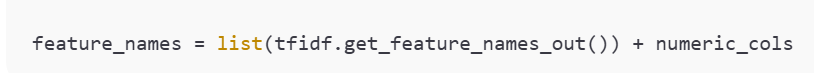

Merges TF-IDF tokens and structured features (CVSS, CWE counts, etc.)

**2. Extracts model coefficients**

- Can be misleadingly high with imbalanced data.

**3.Selects most positive weights**

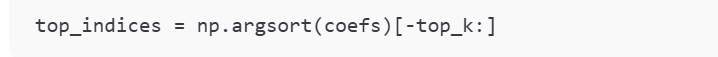

- Shows features most associated with increased exploitation likelihood (class 1).

**3.Pretty prints feature ranking:**
Example output:

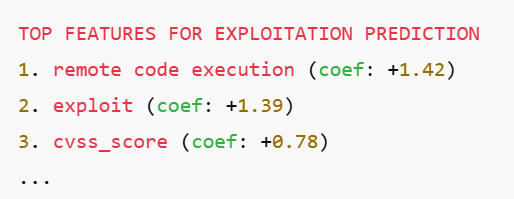



## Save Trained Model

In [74]:
def save_model(model, tfidf, numeric_cols, filepath_prefix="cve_exploitation_lr"):
    """
    Save trained model and preprocessing pipeline.
    """
    joblib.dump(model, f"{filepath_prefix}_model.pkl")
    joblib.dump(tfidf, f"{filepath_prefix}_tfidf.pkl")
    joblib.dump(numeric_cols, f"{filepath_prefix}_numeric_cols.pkl")

    print(f"\nModel saved as:")
    print(f"- {filepath_prefix}_model.pkl")
    print(f"- {filepath_prefix}_tfidf.pkl")
    print(f"- {filepath_prefix}_numeric_cols.pkl")

    return f"{filepath_prefix}_model.pkl"


### What Save Trained Model does :

#### 1.Serializes trained components with joblib.

#### 2. Saves-:
 * The ML classifier (LogReg + calibration).
 * TF-IDF vectorizer.
 * List of numeric feature column names.

### 3.Ensures full reproducibility:
The saved objects are exactly what you need to:
 * Load a model later
 * Transform new CVEs the same way as training
 * Generate KEV exploitation risk predictions

### 4.Prints output for visibility:
 Helpful when running notebooks or pipelines.

### 5.Returns the model file path:
Useful in workflows or automation scripts.

 

## Predict New CVE'S

In [75]:
def predict_new_cves(model, tfidf, numeric_cols, new_cves_df):
    """
    Predict exploitation probability for new CVEs.

    Uses the same feature engineering as `engineer_features`, but:
      - reuses the fitted `tfidf` vectorizer
      - uses the passed `numeric_cols` list to align feature order
    """
    df = new_cves_df.copy()

    # --- Temporal features (same as engineer_features) ---
    df['published'] = pd.to_datetime(df['published'], errors='coerce')
    df['last_modified'] = pd.to_datetime(df['last_modified'], errors='coerce')

    df['age_days'] = (df['last_modified'] - df['published']).dt.days
    df['age_days'] = df['age_days'].fillna(0).clip(lower=0)

    df['published_year'] = df['published'].dt.year
    df['published_month'] = df['published'].dt.month

    # --- CVSS severity numeric (same mapping) ---
    severity_map = {
        'NONE': 0,
        'LOW': 1,
        'MEDIUM': 2,
        'HIGH': 3,
        'CRITICAL': 4
    }
    df['cvss_severity_num'] = df['cvss_severity'].map(severity_map).fillna(0).astype(int)

    # --- CVSS vector flags (same as engineer_features) ---
    vec = df['cvss_vector'].fillna('')

    df['av_network'] = vec.str.contains('AV:N', na=False).astype(int)
    df['av_adjacent'] = vec.str.contains('AV:A', na=False).astype(int)
    df['av_local'] = vec.str.contains('AV:L', na=False).astype(int)
    df['av_physical'] = vec.str.contains('AV:P', na=False).astype(int)

    df['ac_low'] = vec.str.contains('AC:L', na=False).astype(int)
    df['ac_high'] = vec.str.contains('AC:H', na=False).astype(int)

    # --- Ensure all numeric_cols exist and are numeric ---
    for col in numeric_cols:
        if col not in df.columns:
            # For any missing numeric column, just fill with 0
            df[col] = 0
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

    X_num = df[numeric_cols].values

    # --- Text features: use the *same cleaning* and transform with fitted tfidf ---
    desc = (
        df['description']
        .fillna('')
        .str.replace(r'\s+', ' ', regex=True)
        .str.replace(r'[^a-zA-Z0-9 ]', ' ', regex=True)
        .str.lower()
    )
    X_text = tfidf.transform(desc)

    # --- Combine text + numeric in same order/shape as training ---
    X_new = hstack([X_text, X_num]).tocsr()

    # --- Predict ---
    proba = model.predict_proba(X_new)[:, 1]
    predictions = model.predict(X_new)

    results = df[['cve_id', 'cvss_score', 'cvss_severity', 'description']].copy()
    results['exploitation_probability'] = proba
    results['predicted_exploited'] = predictions
    results['risk_score'] = pd.cut(
        proba,
        bins=[0, 0.1, 0.3, 0.7, 1.0],
        labels=['Low', 'Medium', 'High', 'Critical'],
        include_lowest=True
    )

    return results.sort_values('exploitation_probability', ascending=False)




### What Predict New CVE'S does :

#### 1.Copies input & rebuilds engineered features:
 * Parses published and last_modified as datetimes.
 * Computes:
     * age_days = last_modified − published (capped at ≥ 0)
     * published_year, published_month
 * Maps cvss_severity → numeric (NONE=0 … CRITICAL=4).
 * Derives CVSS vector flags (e.g. av_network, ac_low) from cvss_vector.

#### 2. Aligns numeric features with training-:
 * Ensures every column in numeric_cols exists.
 * Fills missing ones with 0 and coerces all to numeric.
 * Builds X_num = df[numeric_cols].values in the same column order as training.

### 3.Reuses the trained TF-IDF text pipeline:

 * Cleans description (normalize whitespace, strip non-alphanumeric, lowercase).
 * Transforms with the fitted tfidf to get X_text.

### 4.Combines features & predicts:
 * Horizontally stacks X_text and X_num with hstack(...).
 * Uses model.predict_proba for exploitation probability and model.predict for class label.

### 5.Builds a ranked output table:
 * Keeps cve_id, cvss_score, cvss_severity, description.
 * Adds:
     * exploitation_probability
     * predicted_exploited (0/1)
     * risk_score bucketed into Low / Medium / High / Critical based on probability.
     * Returns rows sorted by highest exploitation probability.

So effectively: given new flattened CVEs, it rebuilds the same features as training, runs the model, and returns a prioritized risk list of CVEs.
 

## MAIN

Loading CISA KEV data...
Loaded 1468 exploited CVEs from CISA. Sample....
            cveID vendorProject                  product  \
0  CVE-2025-55182          Meta  React Server Components   
1  CVE-2021-26828       OpenPLC                  ScadaBR   
2  CVE-2025-48633       Android                Framework   
3  CVE-2025-48572       Android                Framework   
4  CVE-2021-26829       OpenPLC                  ScadaBR   

                                   vulnerabilityName   dateAdded  \
0  Meta React Server Components Remote Code Execu...  2025-12-05   
1  OpenPLC ScadaBR Unrestricted Upload of File wi...  2025-12-03   
2  Android Framework Information Disclosure Vulne...  2025-12-02   
3  Android Framework Privilege Escalation Vulnera...  2025-12-02   
4  OpenPLC ScadaBR Cross-site Scripting Vulnerabi...  2025-11-28   

                                    shortDescription  \
0  Meta React Server Components contains a remote...   
1  OpenPLC ScadaBR contains an unrestricted 

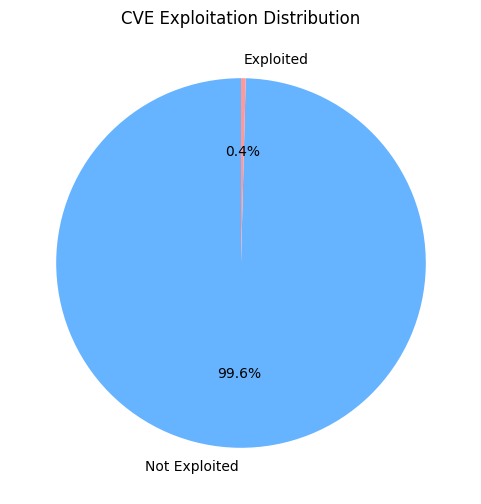


========== CLEANING DATA ==========
Original shape: (16436, 22)

Original vuln_status counts:
vuln_status
Analyzed               7862
Awaiting Analysis      6178
Modified               1834
Rejected                548
Undergoing Analysis      14
Name: count, dtype: int64

Original exploited label counts:
exploited
0    16369
1       67
Name: count, dtype: int64

Cleaned shape: (9710, 22)

Cleaned vuln_status counts:
vuln_status
Analyzed               7862
Modified               1834
Undergoing Analysis      14
Name: count, dtype: int64

Cleaned exploited label counts:
exploited
0    9643
1      67
Name: count, dtype: int64

Head of cleaned dataframe:
           cve_id               published           last_modified vuln_status  \
0  CVE-2024-47475 2025-01-06 17:15:37.423 2025-01-09 16:04:01.680    Analyzed   
1  CVE-2024-56761 2025-01-06 17:15:41.480 2025-01-09 16:16:23.667    Modified   
2  CVE-2024-43063 2025-01-06 11:15:08.930 2025-01-10 15:37:33.340    Analyzed   
3  CVE-2024-3306

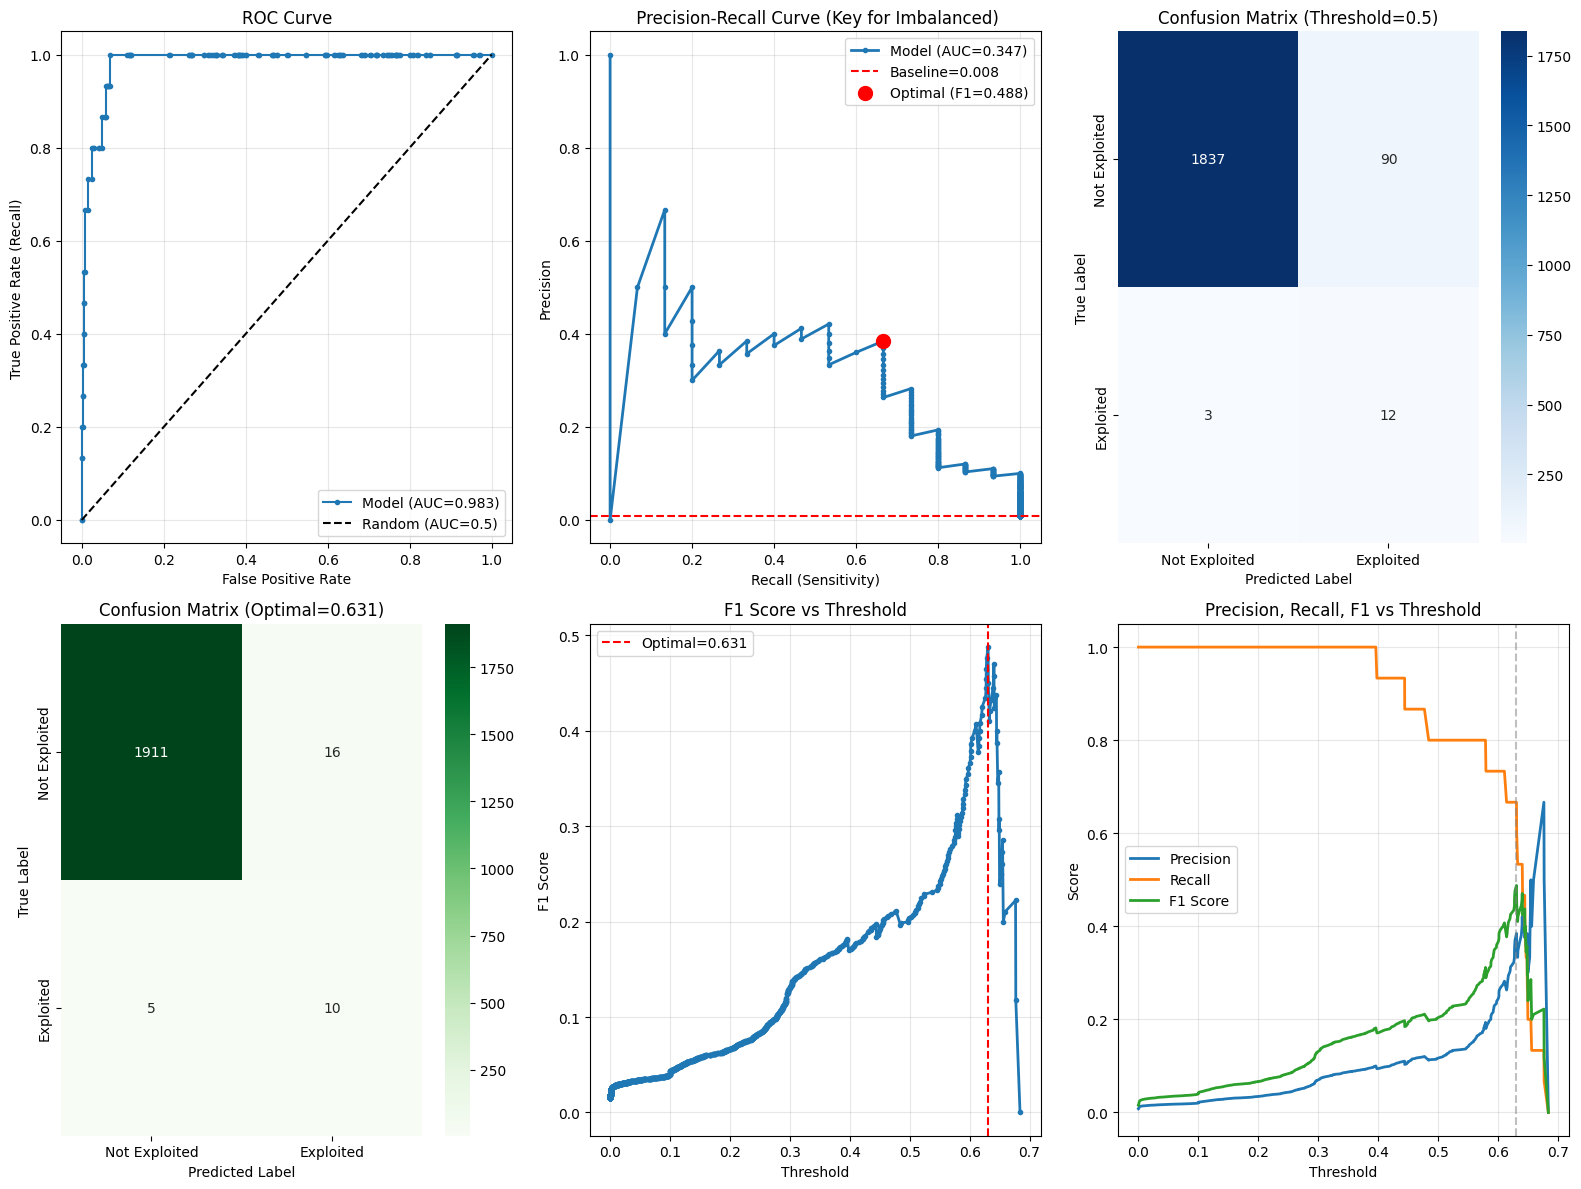


 EVALUATION SUMMARY FOR IMBALANCED DATA

 PR-AUC (0.3466) is the most important metric for your imbalanced data

 ROC-AUC (0.9826) can be optimistic with imbalanced classes

 MCC (0.2956) provides balanced measure even with class imbalance

 Consider using threshold=0.631 instead of 0.5 for better F1


TOP FEATURES FOR EXPLOITATION PREDICTION

Top keywords/phrases / numeric features indicating exploitation:
 1. you                                      (coef:   1.7460)
 2. elevation of                             (coef:   1.7575)
 3. elevation                                (coef:   1.7575)
 4. allows an                                (coef:   1.8652)
 5. nt                                       (coef:   1.8654)
 6. management                               (coef:   1.8728)
 7. have been                                (coef:   1.8748)
 8. an                                       (coef:   1.9088)
 9. files                                    (coef:   1.9105)
10. authentication bypass     

In [76]:
def main():

    # 1. Data Colletion
    kev_ids, kev_df = load_cisa_kev()

    # The maximum allowable range when using any date range parameters is 120 consecutive days. Also, max result per page is 2000
    cve_df = fetch_cves(START_DATE, END_DATE, 2000, "a264b5f4-4416-4670-ab78-00258dcb0e72")

    # 2. Processing
    flatten_cve_df = flatten_cve(cve_df)

    # 3. Label the data
    labelled_cve_df = label_cve_data(flatten_cve_df, kev_ids)

    # 4. Cleaning
    # Before cleaning
    print("\n========== CLEANING DATA ==========")
    print("Original shape:", labelled_cve_df.shape)
    print("\nOriginal vuln_status counts:")
    print(labelled_cve_df['vuln_status'].value_counts())
    print("\nOriginal exploited label counts:")
    print(labelled_cve_df['exploited'].value_counts())

    # Clean the whole dataset (~2000 records)
    clean_df = clean_cve_dataset(labelled_cve_df)

    # After cleaning
    print("\nCleaned shape:", clean_df.shape)
    print("\nCleaned vuln_status counts:")
    print(clean_df['vuln_status'].value_counts())
    print("\nCleaned exploited label counts:")
    print(clean_df['exploited'].value_counts())

    # Quick peek
    print("\nHead of cleaned dataframe:")
    print(clean_df.head())

    # 5. Feature Engineering
    print("\n========== FEATURE ENGINEERING ==========")
    X, y, tfidf, numeric_cols = engineer_features(clean_df)

    print("\nFeature matrix shape (X):", X.shape)   # (n_samples, n_features)
    print("Number of labels (y):", len(y))        # n_samples

    # 6. Temporal train/test split
    train_df, test_df = temporal_train_test_split(clean_df)

     # 7. Prepare train/test features (subset from full feature matrix)
    train_idx = clean_df[clean_df['cve_id'].isin(train_df['cve_id'])].index
    test_idx = clean_df[clean_df['cve_id'].isin(test_df['cve_id'])].index

    X_train = X[train_idx]
    y_train = y[train_idx]
    X_test = X[test_idx]
    y_test = y[test_idx]

    # 8. Train model
    model, y_pred, y_pred_proba = train_model(X_train, y_train, X_test, y_test)

    # 9. Evaluate
    metrics = evaluate_model(model, X_test, y_test, y_pred_proba)

    # 10. Feature importance
    show_top_features(model, tfidf, numeric_cols)

    # 11. Save model
    model_path = save_model(model, tfidf, numeric_cols)

    # 12. High-risk predictions
    results = predict_new_cves(model, tfidf, numeric_cols, test_df)
    print("\nTop 10 Highest Risk CVEs (Test Set):")
    print(results.head(10)[['cve_id', 'exploitation_probability', 'risk_score']].to_csv(index=False))


    # Return everything you’ll likely need later
    return clean_df, X, y, tfidf, numeric_cols, labelled_cve_df, model, metrics, results, model_path


if __name__ == "__main__":
    clean_df, X, y, tfidf, numeric_cols, labelled_cve_df, model, metrics, results, model_path  = main()

---

##  Improving Model Performance: XGBoost + SMOTE

### Why XGBoost + SMOTE?

**XGBoost Benefits:**
-  Handles imbalanced data better than linear models
-  Built-in feature importance
-  Regularization to prevent overfitting
-  Can handle complex non-linear patterns
-  `scale_pos_weight` parameter for class imbalance

**SMOTE Benefits:**
-  Synthetic Minority Over-sampling Technique
-  Creates synthetic examples of minority class
-  Balances the dataset without simply duplicating
-  Helps model learn minority class patterns better

**Combined Power:**
XGBoost with SMOTE-balanced training data + proper evaluation = Better performance on imbalanced data!

In [77]:
# First, let's check if xgboost and imblearn are installed
import sys

try:
    import xgboost as xgb
    print("XGBoost is installed (version: {})".format(xgb.__version__))
except ImportError:
    print("XGBoost not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "xgboost"])
    import xgboost as xgb
    print("XGBoost installed successfully!")

try:
    from imblearn.over_sampling import SMOTE
    print("imbalanced-learn is installed")
except ImportError:
    print(" imbalanced-learn not found. Installing...")
    import subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "imbalanced-learn"])
    from imblearn.over_sampling import SMOTE
    print("imbalanced-learn installed successfully!")

print("\n All required packages are ready!")

XGBoost is installed (version: 3.1.2)
imbalanced-learn is installed

 All required packages are ready!


### Step 1: Apply SMOTE to Balance Training Data

SMOTE creates synthetic samples of the minority class to balance the dataset.

In [78]:
from imblearn.over_sampling import SMOTE

# Prepare training data (already split earlier)
train_df, test_df = temporal_train_test_split(clean_df)
train_idx = clean_df[clean_df['cve_id'].isin(train_df['cve_id'])].index
test_idx = clean_df[clean_df['cve_id'].isin(test_df['cve_id'])].index

X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

print("="*70)
print("ORIGINAL TRAINING DATA")
print("="*70)
print(f"Total samples: {len(y_train)}")
print(f"Negative class (0): {(y_train == 0).sum()} ({(y_train == 0).sum()/len(y_train)*100:.2f}%)")
print(f"Positive class (1): {(y_train == 1).sum()} ({(y_train == 1).sum()/len(y_train)*100:.2f}%)")
print(f"Imbalance ratio: {(y_train == 0).sum() / (y_train == 1).sum():.1f}:1")

# Apply SMOTE
print("\n" + "="*70)
print("APPLYING SMOTE...")
print("="*70)

smote = SMOTE(random_state=SEED, k_neighbors=5)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

print("\n SMOTE Applied Successfully!")
print("\n" + "="*70)
print("SMOTE-BALANCED TRAINING DATA")
print("="*70)
print(f"Total samples: {len(y_train_smote)}")
print(f"Negative class (0): {(y_train_smote == 0).sum()} ({(y_train_smote == 0).sum()/len(y_train_smote)*100:.2f}%)")
print(f"Positive class (1): {(y_train_smote == 1).sum()} ({(y_train_smote == 1).sum()/len(y_train_smote)*100:.2f}%)")
print(f"Imbalance ratio: {(y_train_smote == 0).sum() / (y_train_smote == 1).sum():.1f}:1")

print("\n Note: Test data remains unchanged.")
print(f"Test samples: {len(y_test)} (Positive: {(y_test == 1).sum()})")
print("="*70)

Temporal split: Train 7768 CVEs | Test 1942 CVEs
Train exploited: 52 (0.7%)
Test exploited: 15 (0.8%)
ORIGINAL TRAINING DATA
Total samples: 7768
Negative class (0): 7716 (99.33%)
Positive class (1): 52 (0.67%)
Imbalance ratio: 148.4:1

APPLYING SMOTE...

 SMOTE Applied Successfully!

SMOTE-BALANCED TRAINING DATA
Total samples: 15432
Negative class (0): 7716 (50.00%)
Positive class (1): 7716 (50.00%)
Imbalance ratio: 1.0:1

 Note: Test data remains unchanged.
Test samples: 1942 (Positive: 15)


### Step 2: Train XGBoost Model

Now let's train an XGBoost model on the SMOTE-balanced data.

In [80]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score
import time

print("="*70)
print("TRAINING XGBOOST MODEL WITH SMOTE-BALANCED DATA")
print("="*70)

# XGBoost parameters optimized for imbalanced data
xgb_params = {
    'objective': 'binary:logistic',      # Binary classification
    'eval_metric': 'aucpr',              # Use PR-AUC (better for imbalanced)
    'max_depth': 6,                      # Tree depth
    'learning_rate': 0.1,                # Step size
    'n_estimators': 200,                 # Number of trees
    'subsample': 0.8,                    # Row sampling
    'colsample_bytree': 0.8,             # Feature sampling
    'min_child_weight': 1,               # Minimum sum of instance weight
    'gamma': 0,                          # Minimum loss reduction
    'reg_alpha': 0.1,                    # L1 regularization
    'reg_lambda': 1,                     # L2 regularization
    'random_state': SEED,
    'n_jobs': -1,                        # Use all CPU cores
    'tree_method': 'hist',               # Faster training
}

print("\n XGBoost Parameters:")
for param, value in xgb_params.items():
    print(f"  {param:20s}: {value}")

# Train XGBoost model
print("\n Training XGBoost...")
start_time = time.time()

xgb_model = xgb.XGBClassifier(**xgb_params)
xgb_model.fit(
    X_train_smote, 
    y_train_smote,
    eval_set=[(X_test, y_test)],
    verbose=False
)

training_time = time.time() - start_time

print(f"\n Training completed in {training_time:.2f} seconds")

print(f"\n Save XGBoost Training Model as:")
print(f"\n cve_exploitation_xgb_model.pkl")
joblib.dump(xgb_model, f"(cve_exploitation_xgb_model.pkl")

# Make predictions
y_pred_xgb = xgb_model.predict(X_test)
y_pred_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n Predictions generated")
print("="*70)

TRAINING XGBOOST MODEL WITH SMOTE-BALANCED DATA

 XGBoost Parameters:
  objective           : binary:logistic
  eval_metric         : aucpr
  max_depth           : 6
  learning_rate       : 0.1
  n_estimators        : 200
  subsample           : 0.8
  colsample_bytree    : 0.8
  min_child_weight    : 1
  gamma               : 0
  reg_alpha           : 0.1
  reg_lambda          : 1
  random_state        : 42
  n_jobs              : -1
  tree_method         : hist

 Training XGBoost...

 Training completed in 260.89 seconds

 Save XGBoost Training Model as:

 cve_exploitation_xgb_model.pkl

 Predictions generated


### Step 3: Evaluate XGBoost + SMOTE Model

Let's evaluate the new model using the same comprehensive metrics.


 EVALUATING XGBOOST + SMOTE MODEL

MODEL EVALUATION FOR IMBALANCED DATA

--- Class Distribution in Test Set ---
Class 0: 1927 samples (99.23%)
Class 1: 15 samples (0.77%)

Baseline (% positive class): 0.008

--- Key Metrics for Imbalanced Data ---
ROC-AUC Score:              0.9401
Precision-Recall AUC (PR-AUC): 0.4003  (Better for imbalanced)
Matthews Correlation Coef:  0.3639 (Range: -1 to +1)

Optimal Threshold (F1):     0.0026
Max F1 Score at threshold:  0.4828

Classification Report (Default Threshold = 0.5)
               precision    recall  f1-score   support

Not Exploited     0.9933    1.0000    0.9966      1927
    Exploited     1.0000    0.1333    0.2353        15

     accuracy                         0.9933      1942
    macro avg     0.9966    0.5667    0.6160      1942
 weighted avg     0.9934    0.9933    0.9908      1942


--- Confusion Matrix (Default Threshold = 0.5) ---
[[1927    0]
 [  13    2]]

True Negatives:  1927
False Positives: 0
False Negatives: 13
True P

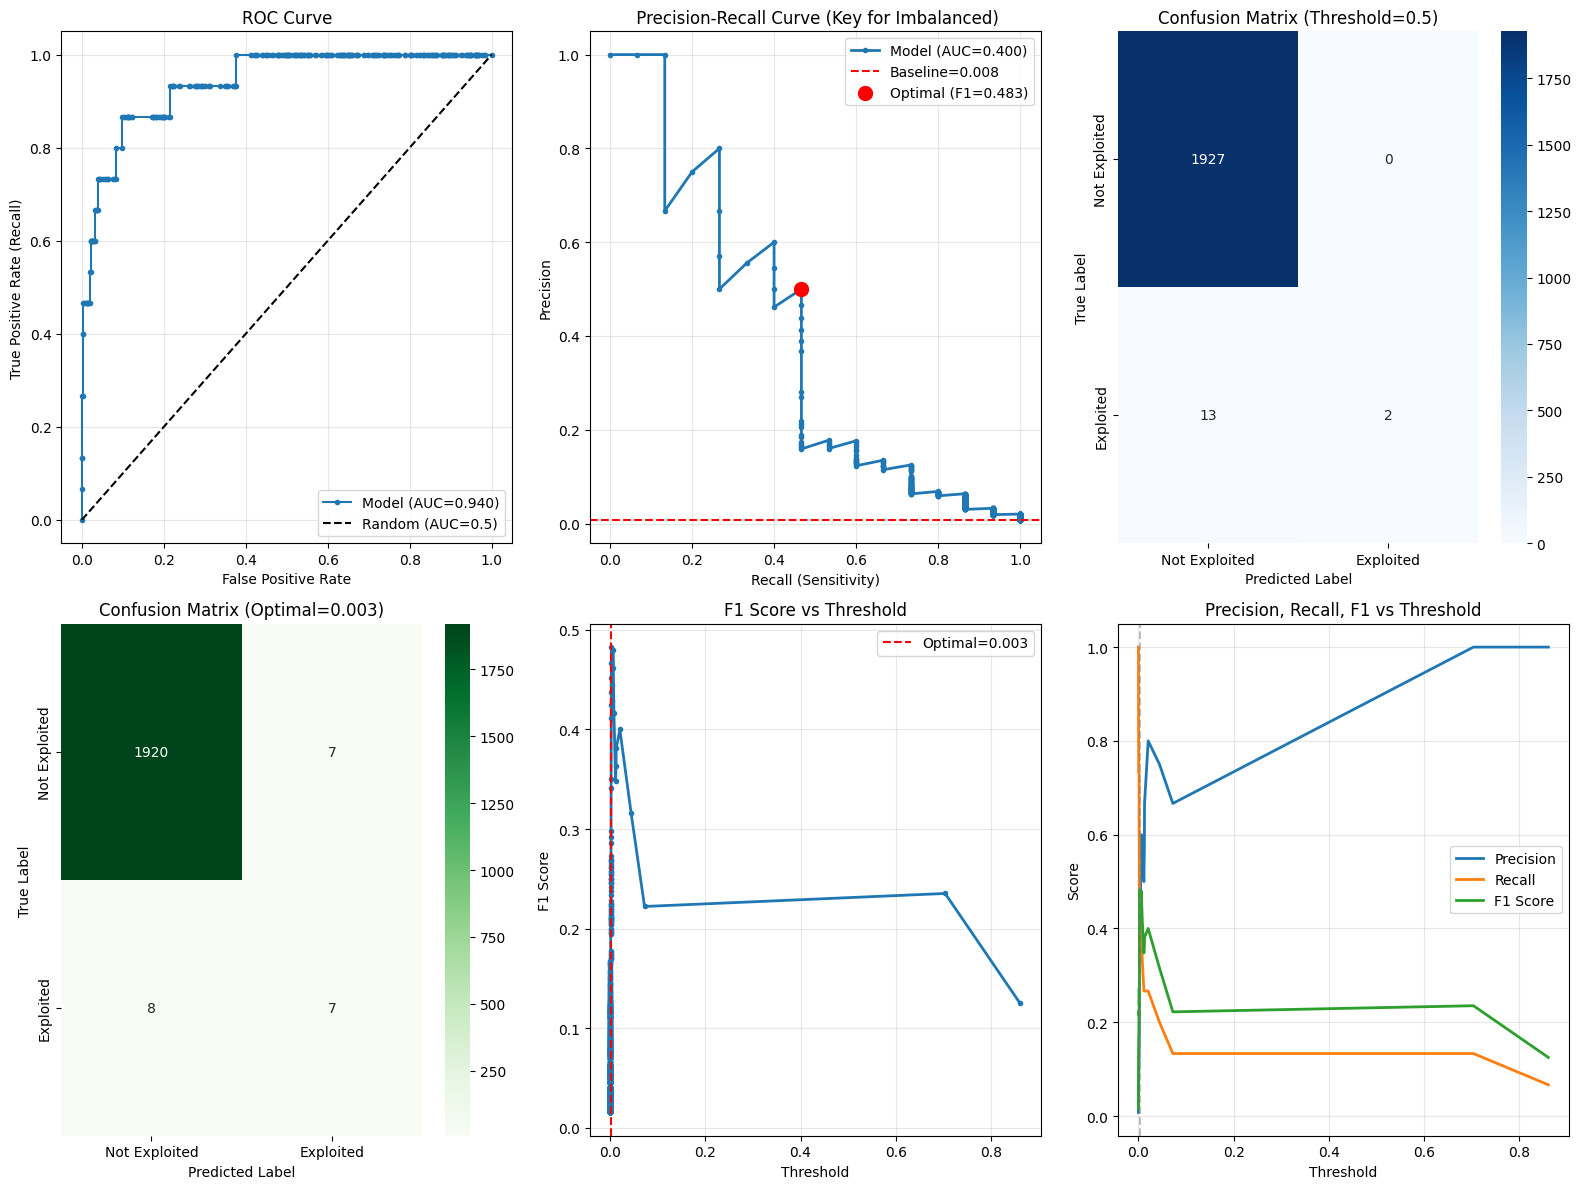


 EVALUATION SUMMARY FOR IMBALANCED DATA

 PR-AUC (0.4003) is the most important metric for your imbalanced data

 ROC-AUC (0.9401) can be optimistic with imbalanced classes

 MCC (0.3639) provides balanced measure even with class imbalance

 Consider using threshold=0.003 instead of 0.5 for better F1



In [59]:
# Evaluate XGBoost + SMOTE model
print("\n" + " EVALUATING XGBOOST + SMOTE MODEL")
xgb_metrics = evaluate_model(xgb_model, X_test, y_test, y_pred_proba_xgb)

### Step 4: Compare All Models

Let's compare Logistic Regression (baseline) vs XGBoost + SMOTE

                MODEL COMPARISON REPORT

DETAILED METRICS COMPARISON
          Metric Logistic Regression (Original) XGBoost + SMOTE Improvement
PR-AUC (Primary)                         0.3466          0.4003      +15.5%
         ROC-AUC                         0.9826          0.9401       -4.3%
             MCC                         0.2956          0.3639      +23.1%
       Precision                         0.1176          1.0000     +750.0%
          Recall                         0.8000          0.1333      -83.3%
        F1-Score                         0.2051          0.2353      +14.7%


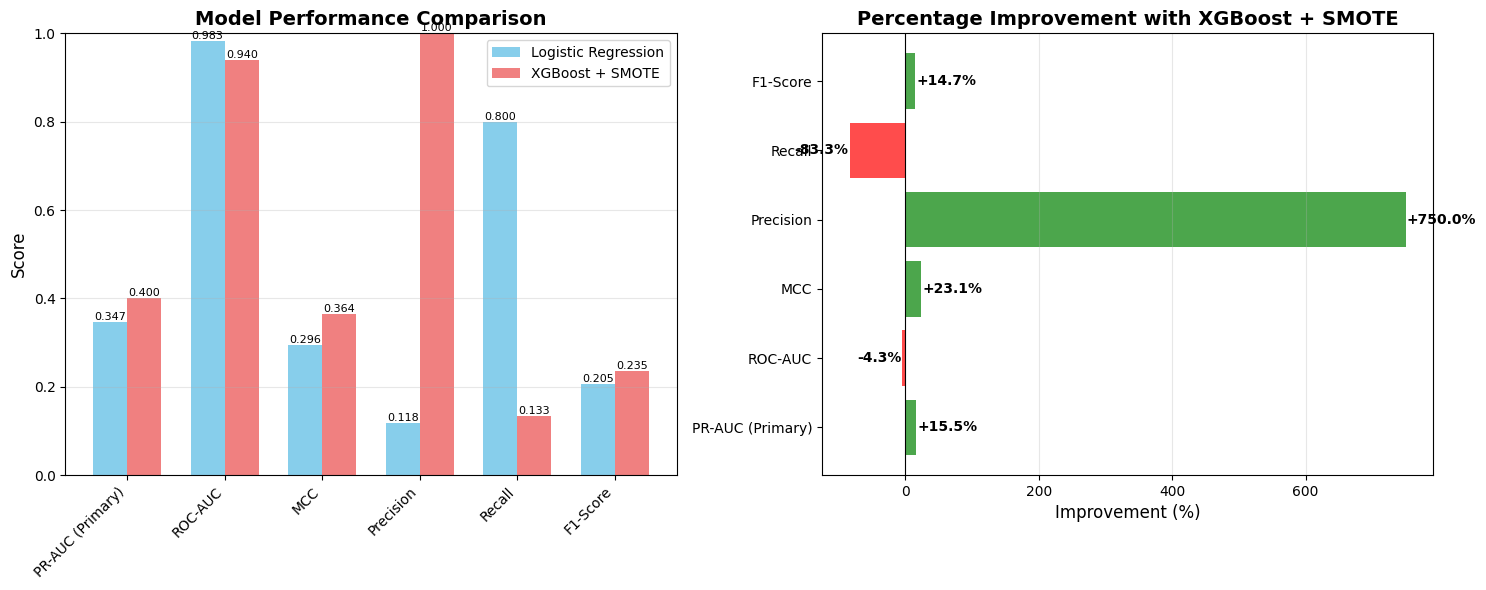


 KEY FINDINGS

 PR-AUC (Most Important): 0.4003 
  IMPROVED by 15.5%

 Recall (Catching exploits): 0.1333
  DECREASED by 83.3%

 XGBoost + SMOTE shows SIGNIFICANT improvement!
   Recommendation: Use XGBoost + SMOTE for production


In [60]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, precision_score, 
    recall_score, f1_score, matthews_corrcoef
)
import matplotlib.pyplot as plt
import pandas as pd

print("="*70)
print(" "*15 + " MODEL COMPARISON REPORT")
print("="*70)

# Get predictions from original Logistic Regression model
y_pred_lr = model.predict(X_test)
y_pred_proba_lr = model.predict_proba(X_test)[:, 1]

# Calculate metrics for both models
models_comparison = {
    'Metric': [],
    'Logistic Regression (Original)': [],
    'XGBoost + SMOTE': [],
    'Improvement': []
}

metrics_to_compare = {
    'PR-AUC (Primary)': (average_precision_score, True),  # True = uses proba
    'ROC-AUC': (roc_auc_score, True),
    'MCC': (matthews_corrcoef, False),  # False = uses binary predictions
    'Precision': (precision_score, False),
    'Recall': (recall_score, False),
    'F1-Score': (f1_score, False),
}

for metric_name, (metric_func, use_proba) in metrics_to_compare.items():
    if use_proba:
        lr_score = metric_func(y_test, y_pred_proba_lr)
        xgb_score = metric_func(y_test, y_pred_proba_xgb)
    else:
        lr_score = metric_func(y_test, y_pred_lr)
        xgb_score = metric_func(y_test, y_pred_xgb)
    
    improvement = ((xgb_score - lr_score) / abs(lr_score) * 100) if lr_score != 0 else 0
    
    models_comparison['Metric'].append(metric_name)
    models_comparison['Logistic Regression (Original)'].append(f"{lr_score:.4f}")
    models_comparison['XGBoost + SMOTE'].append(f"{xgb_score:.4f}")
    models_comparison['Improvement'].append(f"{improvement:+.1f}%")

# Create comparison DataFrame
comparison_df = pd.DataFrame(models_comparison)

print("\n" + "="*70)
print("DETAILED METRICS COMPARISON")
print("="*70)
print(comparison_df.to_string(index=False))

# Visual comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Bar chart comparison
ax1 = axes[0]
metrics_names = list(metrics_to_compare.keys())
lr_scores = [float(comparison_df.iloc[i, 1]) for i in range(len(metrics_names))]
xgb_scores = [float(comparison_df.iloc[i, 2]) for i in range(len(metrics_names))]

x = np.arange(len(metrics_names))
width = 0.35

bars1 = ax1.bar(x - width/2, lr_scores, width, label='Logistic Regression', color='skyblue')
bars2 = ax1.bar(x + width/2, xgb_scores, width, label='XGBoost + SMOTE', color='lightcoral')

ax1.set_ylabel('Score', fontsize=12)
ax1.set_title('Model Performance Comparison', fontsize=14, weight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(metrics_names, rotation=45, ha='right')
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.set_ylim([0, 1])

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

# Improvement chart
ax2 = axes[1]
improvements = [float(comparison_df.iloc[i, 3].rstrip('%')) for i in range(len(metrics_names))]
colors = ['green' if x > 0 else 'red' if x < 0 else 'gray' for x in improvements]

bars = ax2.barh(metrics_names, improvements, color=colors, alpha=0.7)
ax2.set_xlabel('Improvement (%)', fontsize=12)
ax2.set_title('Percentage Improvement with XGBoost + SMOTE', fontsize=14, weight='bold')
ax2.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax2.grid(axis='x', alpha=0.3)

# Add value labels
for i, (bar, val) in enumerate(zip(bars, improvements)):
    label_x = val + (2 if val > 0 else -2)
    ax2.text(label_x, bar.get_y() + bar.get_height()/2, 
            f'{val:+.1f}%', va='center', ha='left' if val > 0 else 'right',
            fontsize=10, weight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(" KEY FINDINGS")
print("="*70)

# Determine winner
pr_auc_improvement = float(comparison_df.iloc[0, 3].rstrip('%'))
recall_improvement = float(comparison_df.iloc[4, 3].rstrip('%'))

print(f"\n PR-AUC (Most Important): {comparison_df.iloc[0, 2]} ")
print(f"  {'IMPROVED' if pr_auc_improvement > 0 else 'DECREASED'} by {abs(pr_auc_improvement):.1f}%")

print(f"\n Recall (Catching exploits): {comparison_df.iloc[4, 2]}")
print(f"  {'IMPROVED' if recall_improvement > 0 else 'DECREASED'} by {abs(recall_improvement):.1f}%")

if pr_auc_improvement > 5:
    print("\n XGBoost + SMOTE shows SIGNIFICANT improvement!")
    print("   Recommendation: Use XGBoost + SMOTE for production")
elif pr_auc_improvement > 0:
    print("\n XGBoost + SMOTE shows modest improvement")
    print("   Recommendation: Consider using XGBoost + SMOTE")
else:
    print("\n  Logistic Regression performs similarly or better")
    print("   Recommendation: Stick with simpler Logistic Regression")
    print("   (Simpler models are easier to interpret and maintain)")

print("="*70)

### Step 5: Feature Importance Analysis (XGBoost)

One advantage of XGBoost is built-in feature importance - let's see which features matter most!

 FEATURE IMPORTANCE ANALYSIS (XGBOOST)

 Top 20 Most Important Features:
----------------------------------------------------------------------
 1. age_days                                      | Importance: 0.0729
 2. attacker                                      | Importance: 0.0713
 3. ios 18                                        | Importance: 0.0441
 4. references_vendor_advisory_count              | Importance: 0.0388
 5. malicious actor                               | Importance: 0.0382
 6. has_exploit_tag                               | Importance: 0.0298
 7. files                                         | Importance: 0.0240
 8. 18 macos                                      | Importance: 0.0192
 9. privileged                                    | Importance: 0.0192
10. host                                          | Importance: 0.0186
11. privilege vulnerability                       | Importance: 0.0182
12. crash                                         | Importance: 0.0179
13. 

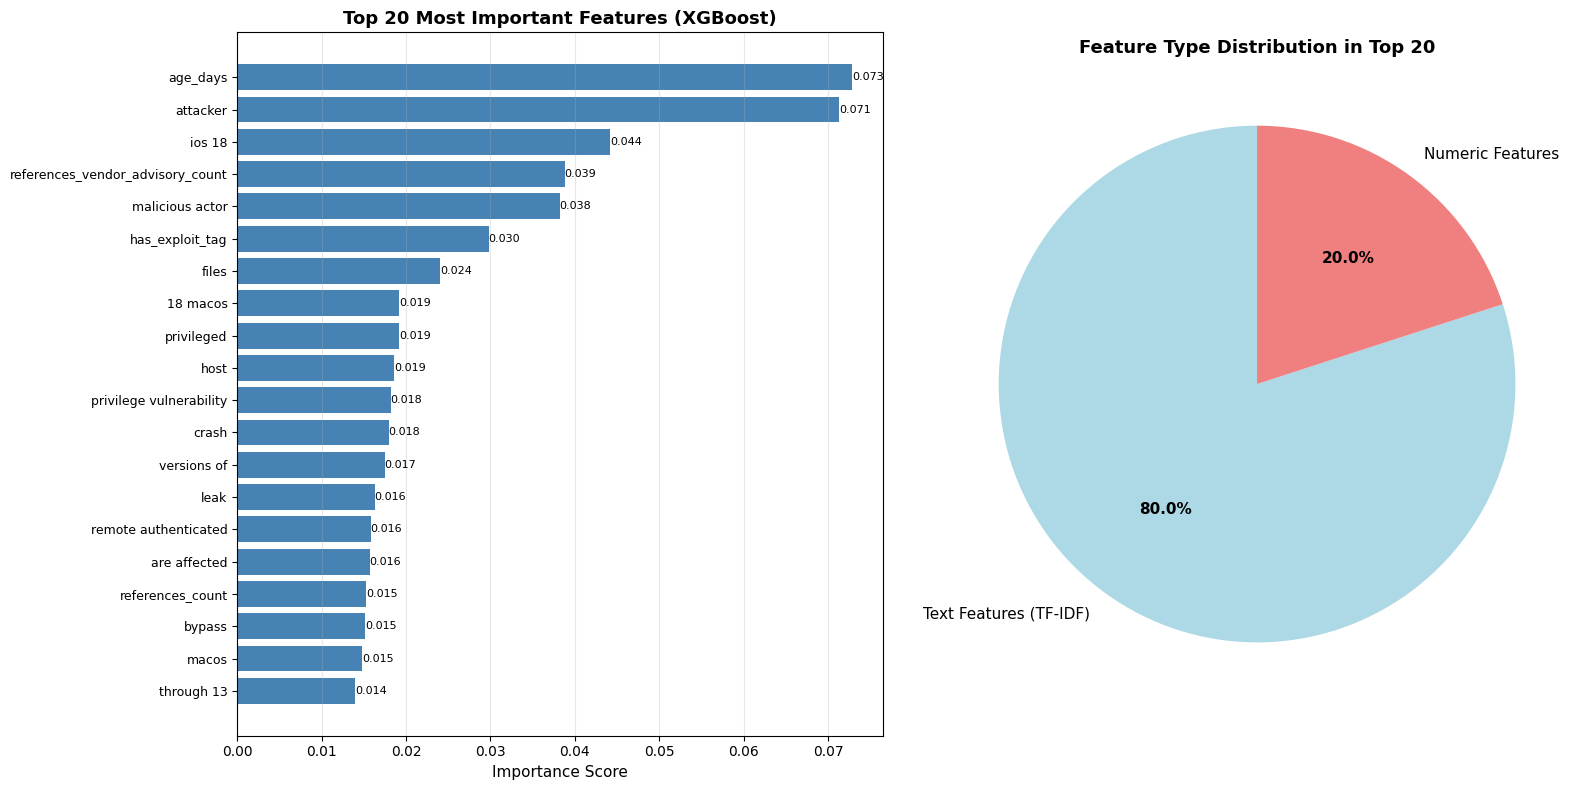


 INSIGHTS

Total features: 5018
  - Text features (TF-IDF): 5000
  - Numeric features: 18

In Top 20:
  - Text features: 16 (80%)
  - Numeric features: 4 (20%)

 Text features (description keywords) are more important
  This suggests description content is highly predictive


In [61]:
import matplotlib.pyplot as plt

print("="*70)
print(" FEATURE IMPORTANCE ANALYSIS (XGBOOST)")
print("="*70)

# Get feature names
feature_names = list(tfidf.get_feature_names_out()) + numeric_cols

# Get feature importance from XGBoost
importance_scores = xgb_model.feature_importances_

# Create DataFrame for sorting
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
}).sort_values('Importance', ascending=False)

# Display top 20 features
print("\n Top 20 Most Important Features:")
print("-" * 70)
top_20 = feature_importance_df.head(20)
for idx, (_, row) in enumerate(top_20.iterrows(), 1):
    feature_name = row['Feature']
    if len(feature_name) > 40:
        feature_name = feature_name[:37] + "..."
    print(f"{idx:2d}. {feature_name:45s} | Importance: {row['Importance']:.4f}")

# Visualize top 20 features
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Bar chart - Top 20
ax1 = axes[0]
top_features = feature_importance_df.head(20)
y_pos = np.arange(len(top_features))

bars = ax1.barh(y_pos, top_features['Importance'].values, color='steelblue')
ax1.set_yticks(y_pos)
ax1.set_yticklabels([f[:40] for f in top_features['Feature'].values], fontsize=9)
ax1.invert_yaxis()
ax1.set_xlabel('Importance Score', fontsize=11)
ax1.set_title('Top 20 Most Important Features (XGBoost)', fontsize=13, weight='bold')
ax1.grid(axis='x', alpha=0.3)

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', fontsize=8)

# Feature type distribution
ax2 = axes[1]

# Categorize features
text_features = top_features[~top_features['Feature'].isin(numeric_cols)]
numeric_features = top_features[top_features['Feature'].isin(numeric_cols)]

feature_types = ['Text Features (TF-IDF)', 'Numeric Features']
counts = [len(text_features), len(numeric_features)]
colors_pie = ['lightblue', 'lightcoral']

wedges, texts, autotexts = ax2.pie(counts, labels=feature_types, autopct='%1.1f%%',
                                     colors=colors_pie, startangle=90,
                                     textprops={'fontsize': 11})
ax2.set_title('Feature Type Distribution in Top 20', fontsize=13, weight='bold')

for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_weight('bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print(" INSIGHTS")
print("="*70)

text_count = len(feature_importance_df[~feature_importance_df['Feature'].isin(numeric_cols)])
numeric_count = len(feature_importance_df[feature_importance_df['Feature'].isin(numeric_cols)])

print(f"\nTotal features: {len(feature_names)}")
print(f"  - Text features (TF-IDF): {text_count}")
print(f"  - Numeric features: {numeric_count}")

print(f"\nIn Top 20:")
print(f"  - Text features: {len(text_features)} ({len(text_features)/20*100:.0f}%)")
print(f"  - Numeric features: {len(numeric_features)} ({len(numeric_features)/20*100:.0f}%)")

# Check if numeric features dominate
if len(numeric_features) > len(text_features):
    print("\n Numeric features (CVSS scores, dates, etc.) are more important")
    print("  This suggests vulnerability metadata is highly predictive")
else:
    print("\n Text features (description keywords) are more important")
    print("  This suggests description content is highly predictive")

print("="*70)

---

##  Summary: XGBoost + SMOTE for Imbalanced Data

###  What We Did:

1. **Applied SMOTE** to balance the training data (minority class oversampling)
2. **Trained XGBoost** with parameters optimized for imbalanced data
3. **Evaluated comprehensively** using metrics appropriate for imbalanced data
4. **Compared models** to see if XGBoost + SMOTE improved performance
5. **Analyzed features** to understand what drives predictions

###  Key Advantages of XGBoost + SMOTE:

| Aspect | Advantage |
|--------|-----------|
| **Class Balance** | SMOTE creates synthetic minority samples → Better learning |
| **Non-linearity** | XGBoost captures complex patterns Linear Regression might miss |
| **Feature Interactions** | Tree-based model naturally handles feature combinations |
| **Regularization** | Built-in L1/L2 prevents overfitting on synthetic data |
| **Interpretability** | Feature importance shows what matters most |
| **Robustness** | Ensemble of trees is more stable than single model |

###  Trade-offs to Consider:

**Advantages:**
-  Often better performance on imbalanced data
-  Handles non-linear patterns
-  Built-in feature importance
-  Less prone to outliers

**Disadvantages:**
-  More complex (harder to explain)
-  Slower training time
-  More hyperparameters to tune
-  Larger model size

###  When to Use Which Model:

**Use Logistic Regression if:**
- Model interpretability is critical
- Training speed matters
- You need to explain coefficients to stakeholders
- Performance is already good enough

**Use XGBoost + SMOTE if:**
- Performance improvement is worth complexity
- You have computational resources
- Non-linear patterns exist in data
- Feature importance is more important than coefficients

---